In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


class HeatPINN(nn.Module):
    def __init__(self):
        super().__init__()
        # Упрощенная архитектура для 1D задачи
        self.net = nn.Sequential(
            nn.Linear(1, 82),  # Вход: координата x
            nn.Tanh(),
            nn.Linear(82, 82),
            nn.Tanh(),
            nn.Linear(82, 1)   # Выход: температура T
        )
    
    def forward(self, x):
        return self.net(x)

In [2]:
def T_exact(x):
            term1 = A * H * (H - x) * x * eps
            term2 = H * (1 + T_left * eps)**2 * lambda0
            term3 = (T_left - T_right) * x * eps * (2 + (T_left + T_right) * eps) * lambda0
            sqrt_term = lambda0 * (term1 + term2 - term3) / H
            return (-lambda0 + np.sqrt(sqrt_term)) / (eps * lambda0)

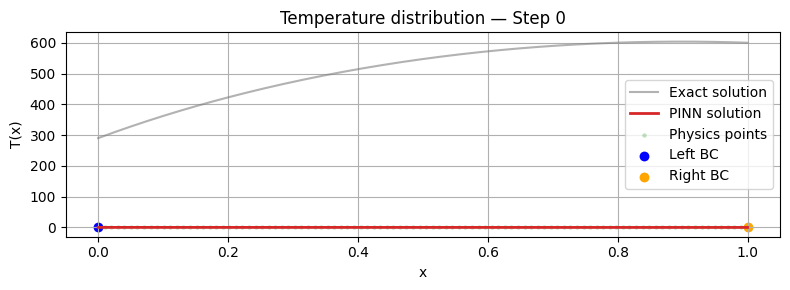

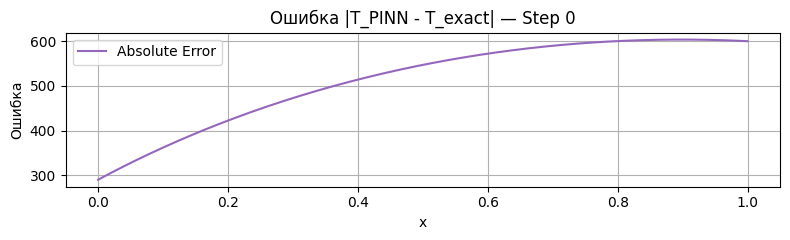

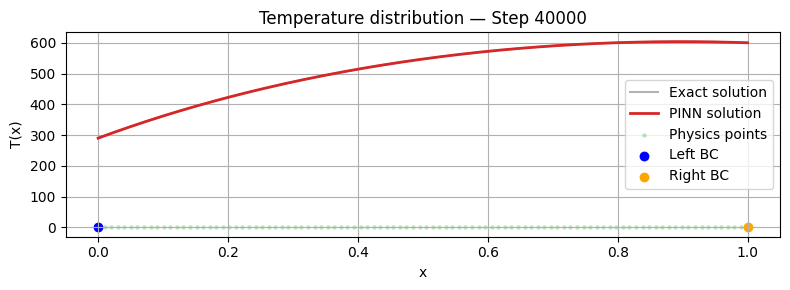

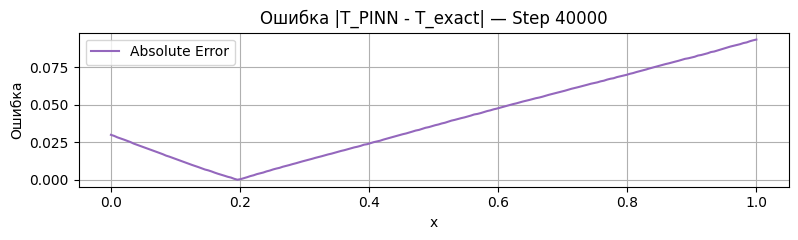

In [3]:
torch.manual_seed(123)
pinn = HeatPINN()
H = 1.0           # Толщина пластины
lambda0 = 40      # Базовый коэффициент теплопроводности [Вт/(м·K)]
T_left = 290      # Температура на левой границе [K]
T_right = 600     # Температура на правой границе [K]
A = 45000         # Мощность внутреннего источника [Вт/м³]
eps = 1e-3        # Коэффициент температурной зависимости

# Граничные точки
x_left = torch.tensor([0.0], requires_grad=True).view(-1, 1)
x_right = torch.tensor([H], requires_grad=True).view(-1, 1)

# Коллокационные точки внутри области
x_physics = torch.linspace(0, H, 100, requires_grad=True).view(-1, 1)

optimiser = torch.optim.Adam(pinn.parameters(),lr=1e-3)

for i in range(50000):
    optimiser.zero_grad()
    lambda1 = 0.01
    lambda2 = 10.0
    # 1. Граничные условия
    T_pred_left = pinn(x_left)
    T_pred_right = pinn(x_right)
    
    loss_left = (T_pred_left - T_left)**2
    loss_right = (T_pred_right - T_right)**2
    
    # 2. Физическое уравнение
    T_physics = pinn(x_physics)
    
    # Первая производная
    dTdx = torch.autograd.grad(
        T_physics, x_physics,
        grad_outputs=torch.ones_like(T_physics),
        create_graph=True
    )[0]
    
    # Вторая производная
    d2Tdx2 = torch.autograd.grad(
        dTdx, x_physics,
        grad_outputs=torch.ones_like(dTdx),
        create_graph=True
    )[0]
    
    # Температурозависимая теплопроводность
    lambda_T = lambda0 * (1 + eps * T_physics)
    
    # Физическое уравнение с (dT/dx)^2
    residual = lambda_T * d2Tdx2 + lambda0 * eps * dTdx**2 + A
    
    # Потери (MSE)
    loss_physics = torch.mean(residual**2)
    
    total_loss = lambda2*(loss_left+loss_right) + lambda1*loss_physics
    total_loss.backward()
    optimiser.step()


    if i % 40000 == 0:
        x_test = torch.linspace(0, H, 200).view(-1, 1)
        T_pred = pinn(x_test).detach()

        x_test_np = x_test.detach().numpy().flatten()
        T_pred_np = T_pred.numpy().flatten()
        T_exact_np = T_exact(x_test_np)

        #  Основной график — решение
        plt.figure(figsize=(8, 3))
        plt.plot(x_test_np, T_exact_np, label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(x_test_np, T_pred_np, label="PINN solution", color="tab:red", lw=2)
        plt.scatter(x_physics.detach().numpy(), 
                    np.zeros_like(x_physics.detach().numpy()), 
                    s=10, lw=0, color="tab:green", alpha=0.3, label="Physics points")
        plt.scatter(x_left.detach().numpy(), [0], s=50, lw=0, color="blue", label="Left BC")
        plt.scatter(x_right.detach().numpy(), [0], s=50, lw=0, color="orange", label="Right BC")
        plt.title(f"Temperature distribution — Step {i}")
        plt.xlabel("x")
        plt.ylabel("T(x)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        #  График ошибки
        abs_error = np.abs(T_pred_np - T_exact_np)
        plt.figure(figsize=(8, 2.5))
        plt.plot(x_test_np, abs_error, color="tab:purple", label="Absolute Error")
        plt.title(f"Ошибка |T_PINN - T_exact| — Step {i}")
        plt.xlabel("x")
        plt.ylabel("Ошибка")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
    

In [8]:
class HeatPINN2(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Linear(1, 64),  # Вход: координата x
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)   # Выход: температура T
        )
    
    def forward(self, x):
        return self.net(x)

In [9]:
def Theta_exact(x,beta):
    beta_x = beta * x
    cosh_bx = torch.cosh(beta_x)
    sinh_bx = torch.sinh(beta_x)
    beta_half = torch.tensor(beta / 2)
    coth_b2 = torch.cosh(beta_half) / torch.sinh(beta_half)
    
    result = cosh_bx - coth_b2 * sinh_bx
    return result

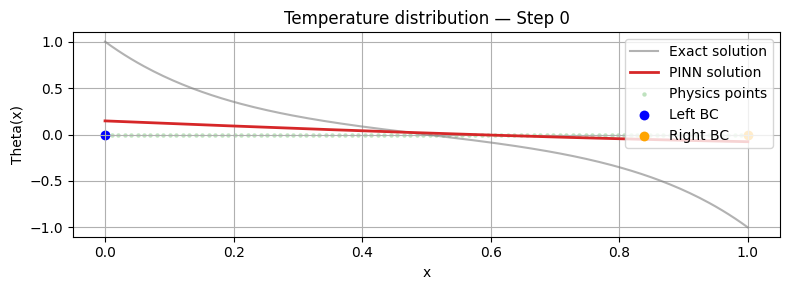

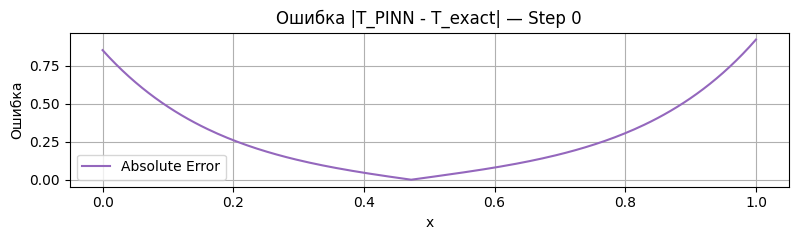

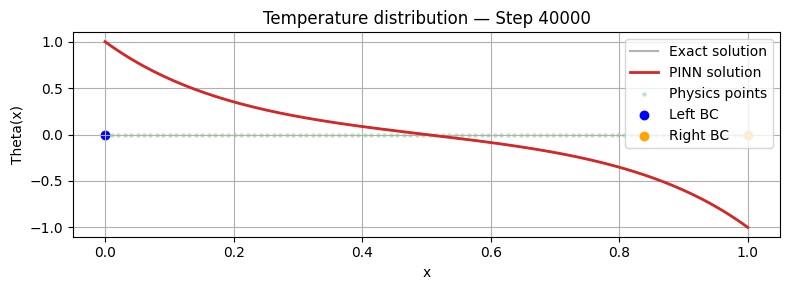

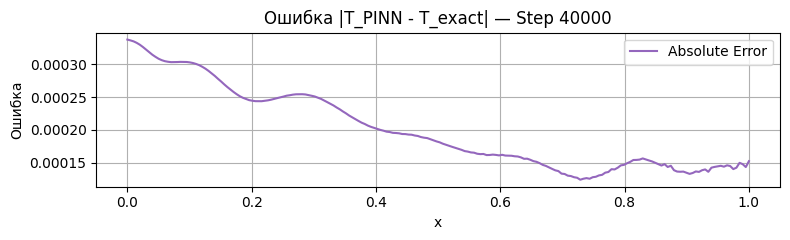

In [10]:
torch.manual_seed(123)
pinn2 = HeatPINN2()
beta = 5.0      # Базовый коэффициент теплопроводности [Вт/(м·K)]
Theta_left = 1      # Температура на левой границе [K]
Theta_right = -1     # Температура на правой границе [K]
H=1.0

# Граничные точки
x_left = torch.tensor([0.0], requires_grad=True).view(-1, 1)
x_right = torch.tensor([H], requires_grad=True).view(-1, 1)

# Коллокационные точки внутри области (больше точек)
x_physics = torch.linspace(0, H, 100, requires_grad=True).view(-1, 1)

optimiser = torch.optim.Adam(pinn2.parameters(),lr=1e-3)

for i in range(50000):
    optimiser.zero_grad()
    lambda1 = 0.01
    lambda2 = 10.0
    # 1. Граничные условия
    Theta_pred_left = pinn2(x_left)
    Theta_pred_right = pinn2(x_right)
    
    loss_left = (Theta_pred_left - Theta_left)**2
    loss_right = (Theta_pred_right - Theta_right)**2
    
    # 2. Физическое уравнение (ОСНОВНОЕ ИСПРАВЛЕНИЕ)
    Theta_physics = pinn2(x_physics)
    
    # Первая производная
    dThetadx = torch.autograd.grad(
        Theta_physics, x_physics,
        grad_outputs=torch.ones_like(Theta_physics),
        create_graph=True
    )[0]
    
    # Вторая производная
    d2Thetadx2 = torch.autograd.grad(
        dThetadx, x_physics,
        grad_outputs=torch.ones_like(dThetadx),
        create_graph=True
    )[0]
  
    
    # Физическое уравнение с (dT/dx)^2
    residual = d2Thetadx2- beta**2*Theta_physics
    
    # Потери (MSE)
    loss_physics = torch.mean(residual**2)
    
    total_loss = lambda2*(loss_left+loss_right) + lambda1*loss_physics
    total_loss.backward()
    optimiser.step()

    if i % 40000 == 0:
        x_test = torch.linspace(0, H, 200).view(-1, 1)
        Theta_pred = pinn2(x_test).detach()
        
        # Вычисляем точное решение — используем torch.Tensor
        Theta_exact_val = Theta_exact(x_test, beta).detach()
        
        # Переводим всё в NumPy для построения графиков
        x_test_np = x_test.numpy().flatten()
        Theta_pred_np = Theta_pred.numpy().flatten()
        Theta_exact_np = Theta_exact_val.numpy().flatten()


        
        plt.figure(figsize=(8, 3))
        plt.plot(x_test_np, Theta_exact_np, label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(x_test_np, Theta_pred_np, label="PINN solution", color="tab:red", lw=2)
        plt.scatter(x_physics.detach().numpy(), 
                    np.zeros_like(x_physics.detach().numpy()), 
                    s=10, lw=0, color="tab:green", alpha=0.3, label="Physics points")
        plt.scatter(x_left.detach().numpy(), [0], s=50, lw=0, color="blue", label="Left BC")
        plt.scatter(x_right.detach().numpy(), [0], s=50, lw=0, color="orange", label="Right BC")
        plt.title(f"Temperature distribution — Step {i}")
        plt.xlabel("x")
        plt.ylabel("Theta(x)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # График ошибки
        abs_error = np.abs(Theta_pred_np - Theta_exact_np)
        plt.figure(figsize=(8, 2.5))
        plt.plot(x_test_np, abs_error, color="tab:purple", label="Absolute Error")
        plt.title(f"Ошибка |T_PINN - T_exact| — Step {i}")
        plt.xlabel("x")
        plt.ylabel("Ошибка")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
    